<a href="https://colab.research.google.com/github/dhalmazna/dspracticum2025-damian/blob/master/Our_NN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Training for Image Classification

This notebook contains the neural network training code for the animal image classification task.
Make sure you have already downloaded and organized your dataset using the `Own_images_NN.ipynb` notebook.

**1. Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import os

**2. Check GPU Availability**

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


**3. Load Dataset**

Load the train and test datasets from the properly structured folders created by the image download notebook.

In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load train and test datasets separately from the split structure
train_dataset = datasets.ImageFolder(root='./animals_dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./animals_dataset/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")

Train dataset size: 636
Test dataset size: 215
Classes: ['capybara', 'cat', 'dog', 'owl', 'rabbit']
Number of classes: 5


**4. Display Sample Image**

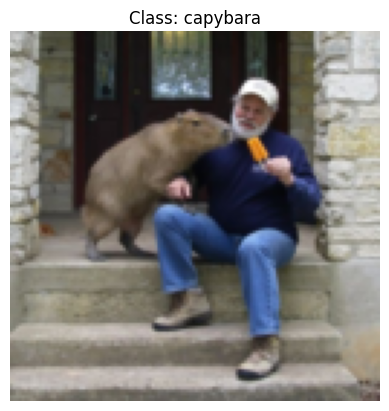

In [4]:
# Display a sample image from the train dataset
img_tensor = train_dataset[100]  # Use a smaller index

# If it's a tuple like (tensor, label), unpack it:
if isinstance(img_tensor, tuple):
    img_tensor, label = img_tensor

# Convert from (C, H, W) to (H, W, C)
img = img_tensor.permute(1, 2, 0).numpy()

# Plot
plt.imshow(img)
plt.axis("off")
plt.title(f"Class: {train_dataset.classes[label]}")
plt.show()

**5. Define Neural Network Model**

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=124*124*64, out_features=128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=5)  # 5 classes: cat, dog, rabbit, capybara, owl

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=984064, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

**6. Define Loss Function & Optimizer**

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

**7. Training Loop**

In [7]:
for epoch in range(5):  # Train for 5 epochs
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/5], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/5], Loss: 1.6423
Epoch [2/5], Loss: 1.5876
Epoch [3/5], Loss: 1.5721
Epoch [4/5], Loss: 1.5364
Epoch [5/5], Loss: 1.5191


**8. Evaluation on Test Set**

In [8]:
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 25.58%


**9. Visualize Predictions**

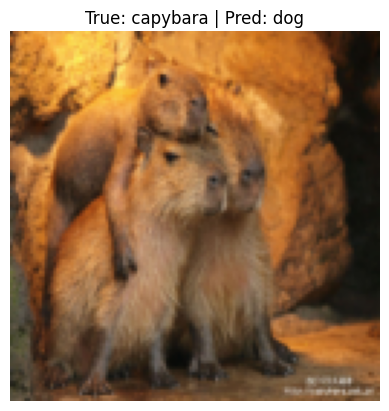

In [9]:
# Get one batch from test_loader
images, labels = next(iter(test_loader))

# Move to device
images = images.to(device)
labels = labels.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Pick the nth image in the batch
n=11 # n=4,5 top
img = images[n].cpu().permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
true_label = train_dataset.classes[labels[n].item()]
pred_label = train_dataset.classes[predicted[n].item()]

# Show the image
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_label} | Pred: {pred_label}")
plt.show()